<a href="https://colab.research.google.com/github/channachot/Project1/blob/master/Project3_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision.utils as vutils
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [0]:
import os
from glob import glob

#WEIGHTS_FOLDER = 'weights'
#DATA_FOLDER = '/content/drive/My Drive/colab/'

#if not os.path.exists(WEIGHTS_FOLDER):
 # os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
 # os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/colab/animefacedataset.zip', 'r') as zipObj:
    #Extract all the contents of zip file in the data directory
    zipObj.extractall('/content/drive/My Drive/colab/imagesGAN')

In [0]:
num_channels = 3
latent_size = 100
base_size, image_size, batch_size = 64, 64, 64
torch.cuda.set_device("cuda:0")

#Get Data

In [0]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # makes value in between [-1, 1]
])

dataset = datasets.ImageFolder('/content/drive/My Drive/colab/imagesGAN', transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

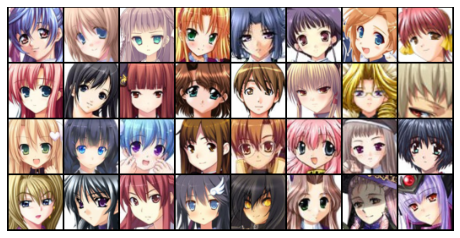

In [7]:
real_batch = next(iter(loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
#Network
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

    
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 128, image_size//4, image_size//4)

def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)
                    ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

In [0]:
#Generator
G = nn.Sequential(
    nn.Linear(100, 128 * (image_size//4) ** 2),
    UnFlatten(),
    nn.BatchNorm2d(128),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(128, 128, 3, stride=1, padding=1),
    nn.BatchNorm2d(128, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(128, 64, 3, stride=1, padding=1),
    nn.BatchNorm2d(64, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, num_channels, 3, stride=1, padding=1),
    nn.Tanh(),
)

In [0]:
#Discriminator
D = nn.Sequential(
    *discriminator_block(num_channels, 16, bn=False),
    *discriminator_block(16, 32),
    *discriminator_block(32, 64),
    *discriminator_block(64, 128),
    Flatten(),
    nn.Linear(128 * (image_size//2**4) ** 2, 1), 
    nn.Sigmoid()
)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# recursively apply weights initialization on every submodule
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout2d(p=0.25, inplace=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout2d(p=0.25, inplace=False)
  (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Dropout2d(p=0.25, inplace=False)
  (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): LeakyReLU(negative_slope=0.2, inplace=True)
  (13): Dropout2d(p=0.25, inplace=False)
  (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (15): Flatten()
  (16): Linear(in_features=2048, out_features=1, bias

In [0]:
def draw_my_picture():
    Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_size))))
    img = G(z).cpu().data[0]
    img = img.view((num_channels, image_size, image_size)).transpose(0, 1).transpose(1, 2).cpu().numpy()
    plt.axis('off')
    plt.imshow(img.reshape(image_size, image_size, num_channels))
    plt.show()


In [13]:
try:
    D.load_state_dict(torch.load('D.pth'))
    G.load_state_dict(torch.load('G.pth'))
except:
    print("Weights not found ):")

Weights not found ):


In [0]:
cuda = True if torch.cuda.is_available() else False
adversarial_loss = torch.nn.BCELoss()
if cuda:
    G.cuda()
    D.cuda()
    adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    Tensor = torch.FloatTensor

#Train


  0%|          | 0/30 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


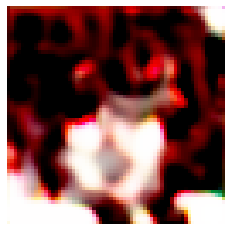

  3%|▎         | 1/30 [07:59<3:51:51, 479.71s/it]

D_loss: 0.3752 G_loss: 2.5869


  7%|▋         | 2/30 [15:54<3:43:08, 478.16s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


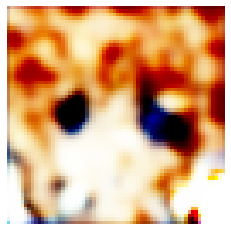

 10%|█         | 3/30 [23:47<3:34:29, 476.65s/it]

D_loss: 0.4123 G_loss: 1.8033


 13%|█▎        | 4/30 [31:40<3:26:06, 475.64s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


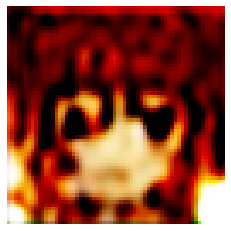

 17%|█▋        | 5/30 [39:35<3:18:01, 475.28s/it]

D_loss: 0.5207 G_loss: 2.0003


 20%|██        | 6/30 [47:32<3:10:23, 476.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


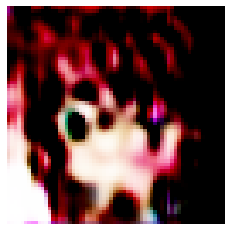

 23%|██▎       | 7/30 [55:30<3:02:41, 476.60s/it]

D_loss: 0.4878 G_loss: 1.1160


 27%|██▋       | 8/30 [1:03:33<2:55:23, 478.36s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


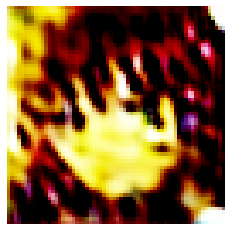

 30%|███       | 9/30 [1:11:32<2:47:28, 478.49s/it]

D_loss: 0.4767 G_loss: 1.6621


 33%|███▎      | 10/30 [1:19:30<2:39:32, 478.60s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


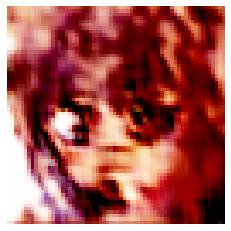

 37%|███▋      | 11/30 [1:27:26<2:31:19, 477.84s/it]

D_loss: 0.6702 G_loss: 0.9977


 40%|████      | 12/30 [1:35:17<2:22:43, 475.76s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


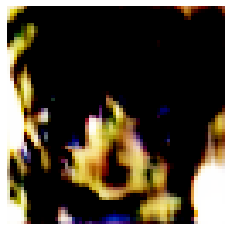

 43%|████▎     | 13/30 [1:42:55<2:13:16, 470.37s/it]

D_loss: 0.7203 G_loss: 0.9769


 47%|████▋     | 14/30 [1:50:43<2:05:13, 469.58s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


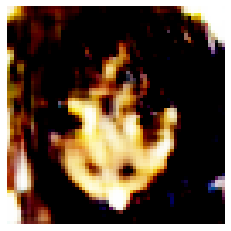

 50%|█████     | 15/30 [1:58:20<1:56:27, 465.82s/it]

D_loss: 0.6035 G_loss: 0.9763


 53%|█████▎    | 16/30 [2:06:01<1:48:22, 464.48s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


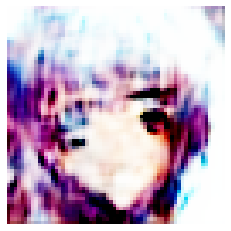

 57%|█████▋    | 17/30 [2:13:38<1:40:07, 462.14s/it]

D_loss: 0.6781 G_loss: 0.7112


 60%|██████    | 18/30 [2:21:14<1:32:04, 460.39s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


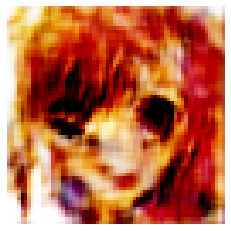

 63%|██████▎   | 19/30 [2:28:51<1:24:12, 459.32s/it]

D_loss: 0.7007 G_loss: 0.8245


 67%|██████▋   | 20/30 [2:36:26<1:16:20, 458.01s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


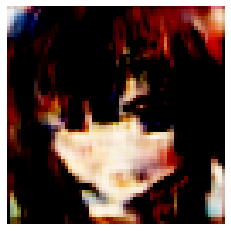

 70%|███████   | 21/30 [2:44:01<1:08:32, 457.00s/it]

D_loss: 0.6589 G_loss: 0.7149


 73%|███████▎  | 22/30 [2:51:36<1:00:51, 456.42s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


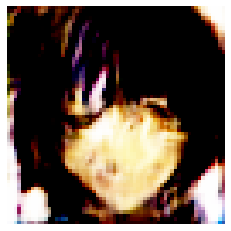

 77%|███████▋  | 23/30 [2:59:13<53:16, 456.66s/it]  

D_loss: 0.6243 G_loss: 0.7392


 80%|████████  | 24/30 [3:06:50<45:40, 456.82s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


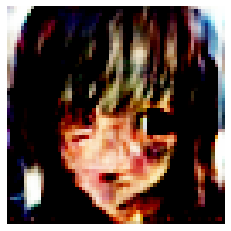

 83%|████████▎ | 25/30 [3:14:25<38:01, 456.30s/it]

D_loss: 0.5987 G_loss: 1.0725


 87%|████████▋ | 26/30 [3:22:00<30:22, 455.74s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


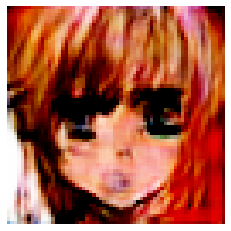

 90%|█████████ | 27/30 [3:29:32<22:44, 454.85s/it]

D_loss: 0.5162 G_loss: 1.0196


 93%|█████████▎| 28/30 [3:37:08<15:10, 455.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


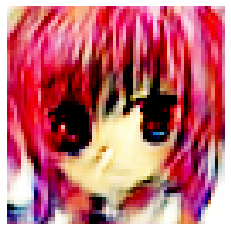

 97%|█████████▋| 29/30 [3:45:04<07:41, 461.48s/it]

D_loss: 0.6380 G_loss: 0.6752


100%|██████████| 30/30 [3:52:37<00:00, 465.25s/it]


In [15]:
num_epochs = 30
learning_rate = 1e-3

optim_G = torch.optim.Adam(G.parameters(), lr=learning_rate)
optim_D = torch.optim.Adam(D.parameters(), lr=learning_rate)
criterion_G = nn.BCELoss()
criterion_D = nn.BCELoss()
for epoch in tqdm(range(num_epochs)):
    for imgs, _ in loader:
        # Train Generator
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))

        optim_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_size)))) # Sample noise
        gen_imgs = G(z)
        G_loss = adversarial_loss(D(gen_imgs), valid)

        G_loss.backward()
        optim_G.step()

        #  Train Discriminator
        optim_D.zero_grad()
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        D_loss = (real_loss + fake_loss) / 2

        D_loss.backward()
        optim_D.step()
    if epoch % 2 == 0:
        D.eval()
        G.eval()
        draw_my_picture()        
        print(f"D_loss: {D_loss.item():.4f} G_loss: {G_loss.item():.4f}")
        torch.save(D.state_dict(), 'D.pth')
        torch.save(G.state_dict(), 'G.pth')
        D.train()
        G.train()

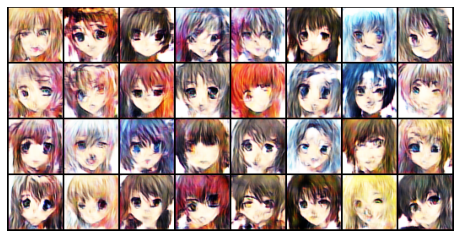

In [16]:
z = Variable(Tensor(np.random.normal(0, 1, (32, latent_size)))) # Sample noise
gen_imgs = G(z).detach().cpu()
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_imgs, padding=2, normalize=True).cpu(),(1,2,0)))